### Time series analysis and classification project

### Describtion  and objectifs
#### Title: Analyzing the Evolution of R Programming Language Interest on Stack Overflow
This project delves into the historical data encompassing the frequency of questions asked on Stack Overflow related to the R programming language from 2009 to February 2024. The primary objectives of this endeavor are twofold: to examine the trajectory of R language interest over time and to forecast the future trend of monthly question volumes concerning R on Stack Overflow.

Through comprehensive data analysis, the project aims to uncover patterns and trends in the evolution of R language usage and interest within the Stack Overflow community. By scrutinizing the historical question counts, we seek to gain insights into the fluctuations and growth dynamics of R-related inquiries over the years, thereby illuminating the ebb and flow of interest in the language among developers and data enthusiasts.

Furthermore, leveraging time series forecasting techniques, the project endeavors to provide predictive models for estimating the future volumes of monthly questions about R on Stack Overflow. By extrapolating from past trends and incorporating relevant factors, such as technological advancements, industry trends, and the growing adoption of data science and analytics, these forecasts aim to offer valuable insights into the prospective trajectory of R language interest on the platform.

**here is the link of the data:** 
[Data link](https://www.kaggle.com/datasets/computingvictor/monthly-trends-in-stack-overflow-questions)


In [1]:
library(forecast)
library(lubridate)
library(TSA)
library(zoo)
library(MASS)
library(VGAM)
library(bestNormalize)
library(tseries)

options(repr.plot.width=10, repr.plot.height=6)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 methods overwritten by 'TSA':
  method       from    
  fitted.Arima forecast
  plot.Arima   forecast


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: stats4

Loading required package: splines


Attaching package: ‘bestNormalize’


The following object is masked from ‘package:MASS’:

    boxcox




#### We read the data from csv file

In [2]:
data <- read.csv('R.csv')

## DATA PREPROCESSING AND CLEANING
In this section, we will perform the necessary steps for data preprocessing and cleaning to prepare our dataset for analysis. Data preprocessing is crucial to ensure that the data is in a suitable format and quality for further analysis.

In [3]:
#we look the the type of the data
str(data)

'data.frame':	185 obs. of  2 variables:
 $ Month: chr  "2008-09-01" "2008-11-01" "2008-12-01" "2009-01-01" ...
 $ R    : int  6 1 1 8 8 4 12 2 5 50 ...


**In this context, we observe that the 'Month' attribute is currently represented as a character type. We need to perform the necessary adjustments to convert it into a date type.**

In [4]:
#we convert into date type
data$Month <- as.Date(data$Month)


#### Plot the data 

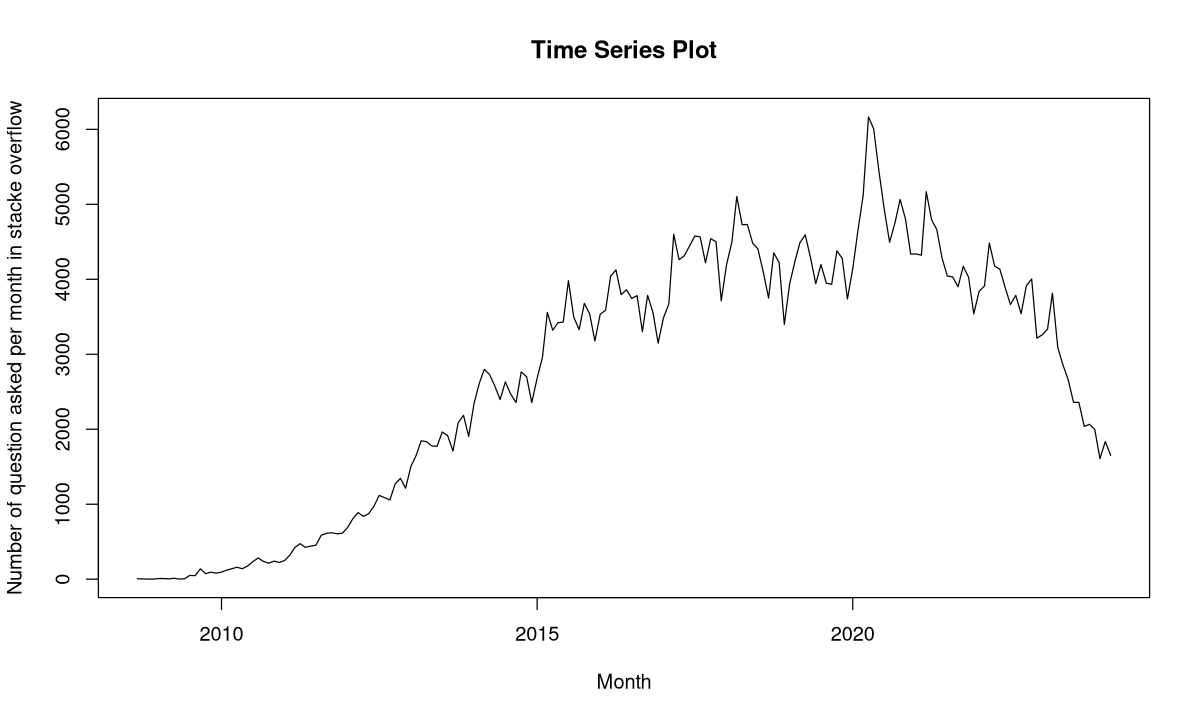

In [5]:
plot(data$Month, data$R, type = "l", xlab = "Month", ylab = "Number of question asked per month in stacke overflow", main = "Time Series Plot")

### **Then we split the data into training and testing, in here for the testing i will take only 30 last points of my data, given that i have 185 points in total**

In [6]:
train_data <- head(data, -30)
test_data <- tail(data, 30)

### **BOX-COX Transformation**

##### Here, we execute the Box-Cox transformation to stabilize the variance. Stabilizing the variance serves as the initial step in this process.

In [7]:
lambda <- BoxCox.lambda(train_data)

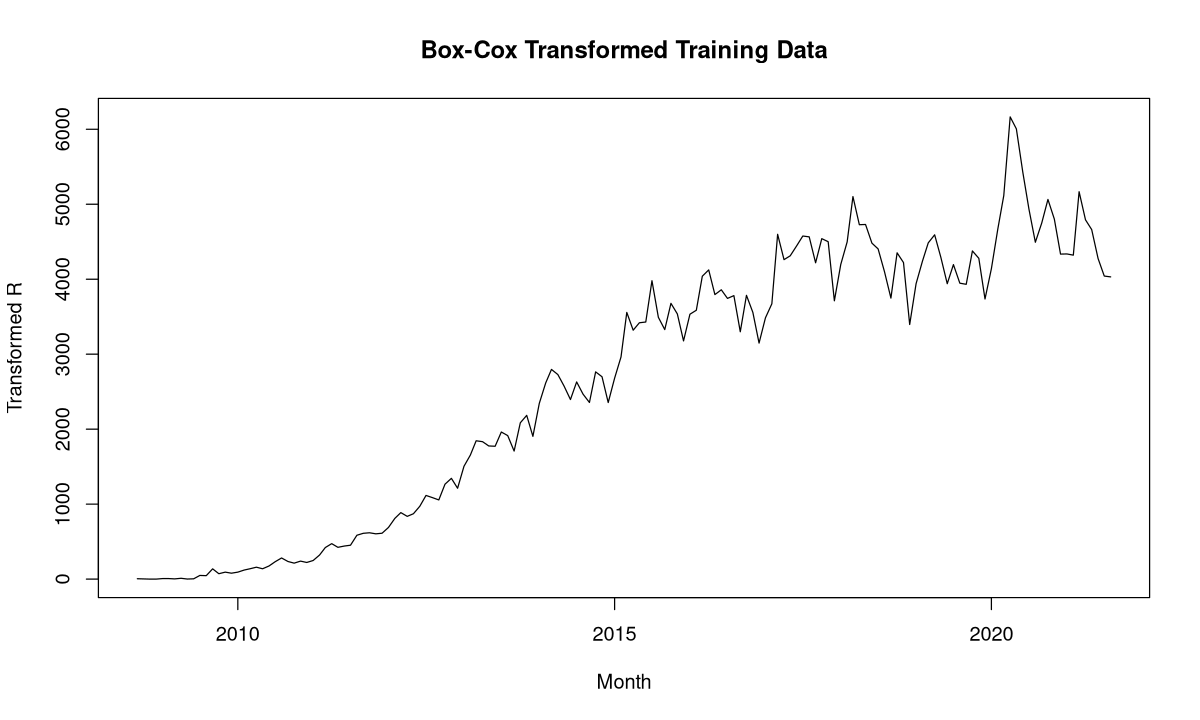

In [8]:
transformed_data <- BoxCox(lambda = lambda , train_data$R)

plot(transformed_data, x = train_data$Month, type = 'l', xlab = 'Month', ylab = 'Transformed R', main = 'Box-Cox Transformed Training Data')




### Assessing Stationarity

##### To examine stationarity, we employ the Augmented Dickey-Fuller (ADF) test to ascertain whether our data exhibits stationary behavior.

In [9]:
library(tseries)



# Perform ADF test on the original training data
adf_original <- adf.test(transformed_data)
print("ADF Test on transform Training Data:")
print(adf_original)

[1] "ADF Test on transform Training Data:"

	Augmented Dickey-Fuller Test

data:  transformed_data
Dickey-Fuller = -1.4823, Lag order = 5, p-value = 0.7922
alternative hypothesis: stationary



#### **For the original training data, the p-value is 0.7922. Since this p-value is greater than the typical significance level of 0.05, we fail to reject the null hypothesis, indicating that the original training data is non-stationary.**

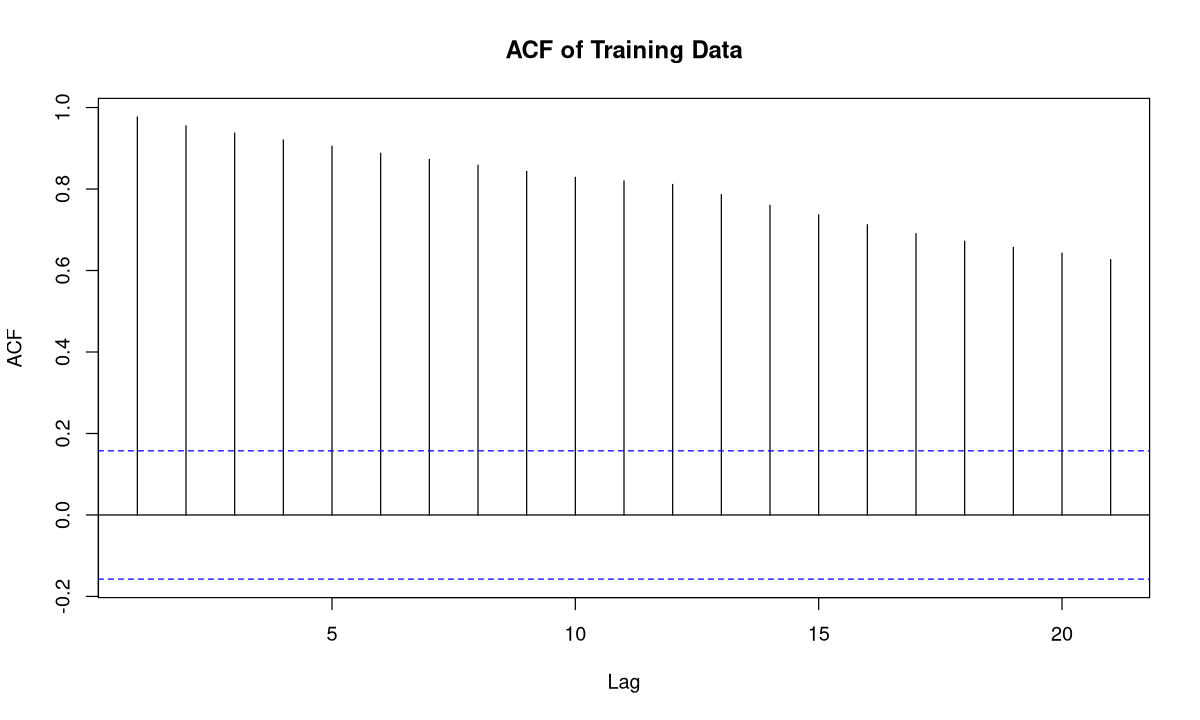

In [10]:
acf(train_data$R, main = "ACF of Training Data")

##### **The decreasing trend observed in the autocorrelation function (ACF) suggests the presence of underlying trends in the data, To solve this, differencing is recommended.**

### Perform Differencing

##### Differencing involves subtracting each observation from its previous observation to remove trends o from the time series data. This process helps achieve stationarity by stabilizing the mean over time.


In [11]:
differenced_train_data <- diff(transformed_data)

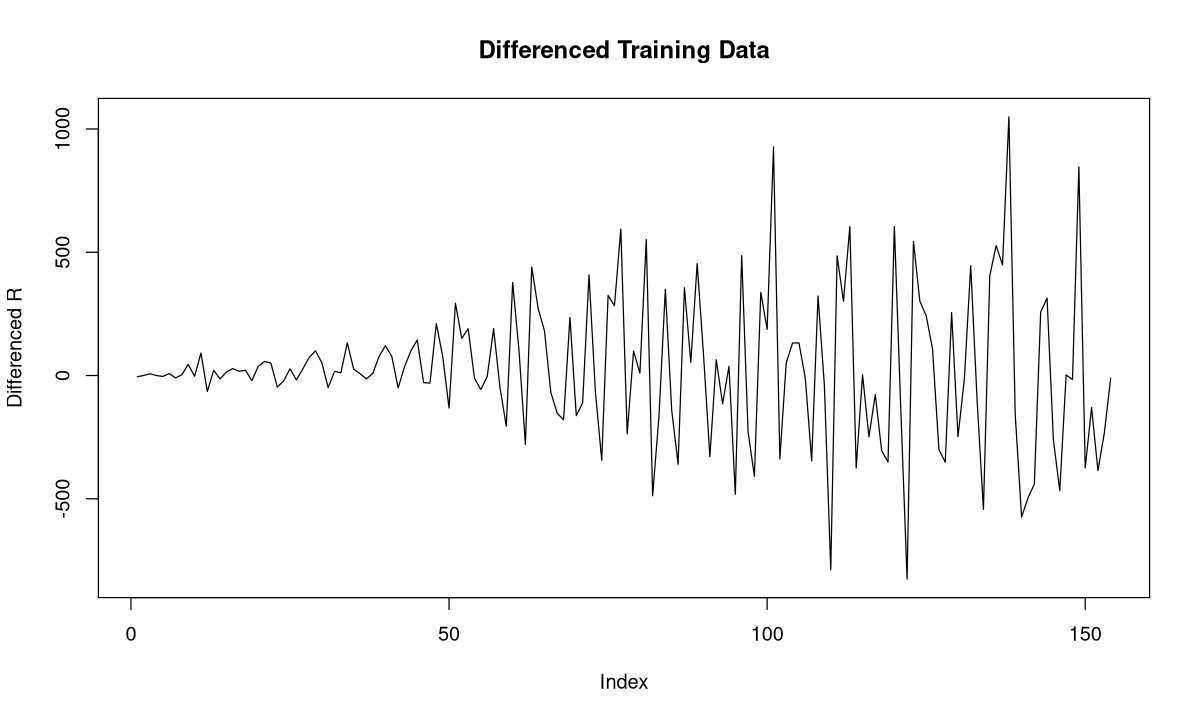

In [12]:
plot(differenced_train_data, type = 'l', xlab = 'Index', ylab = 'Differenced R', main = 'Differenced Training Data')

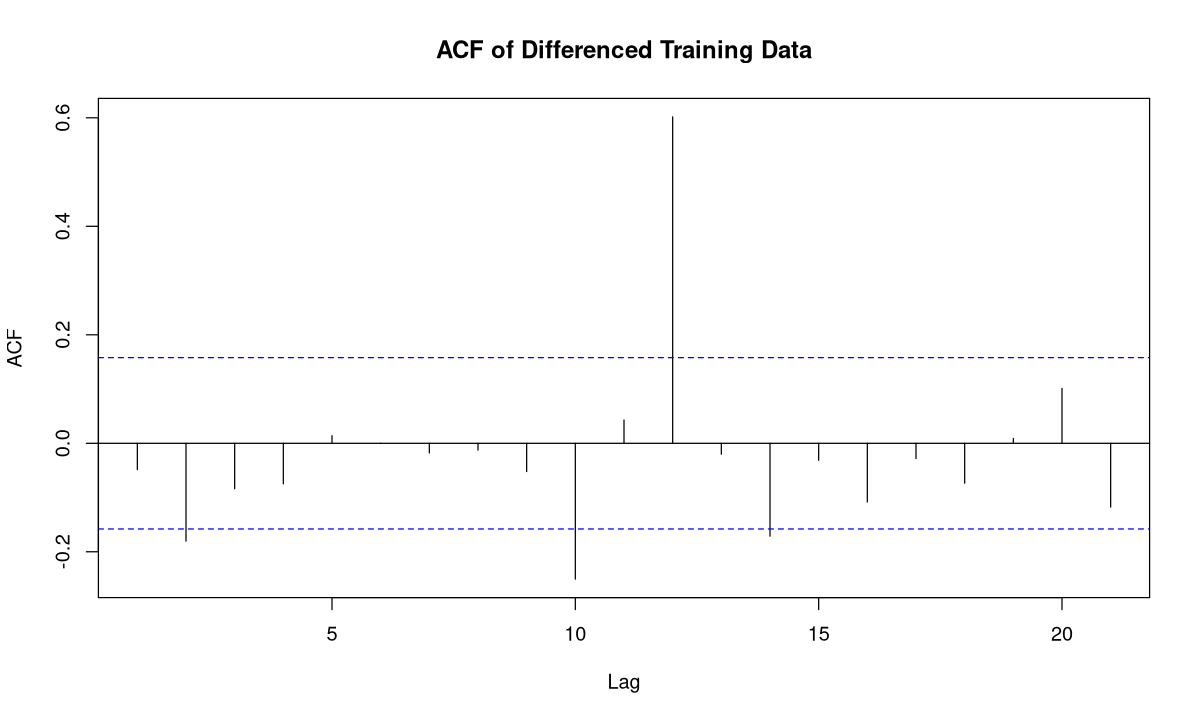

In [13]:
acf(differenced_train_data, main = "ACF of Differenced Training Data")

#### **we perform the adf test to check the stationarity**

In [14]:
# Perform ADF test on the differenced training data
adf_differenced <- adf.test(differenced_train_data)
print("ADF Test on Differenced Training Data:")
print(adf_differenced)


Warning message in adf.test(differenced_train_data):
“p-value smaller than printed p-value”


[1] "ADF Test on Differenced Training Data:"

	Augmented Dickey-Fuller Test

data:  differenced_train_data
Dickey-Fuller = -6.2984, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



  
##### **For the differenced training data, the p-value is 0.01. This p-value is less than the typical significance level of 0.05, so we reject the null hypothesis in favor of the alternative hypothesis, indicating that the differenced training data is stationary.**



## Modeling the Data 

 We begin by identifying potential orders for the ARIMA model using the autocorrelation function (ACF), partial autocorrelation function (PACF), and additional methods like the Akaike information criterion (AIC) and Bayesian information criterion (BIC). Lower values of these criteria indicate better model performance, striking a balance between goodness of fit and model complexity. Subsequently, we employ the auto.arima() function in R to generate a set of candidate models. We then conduct residual diagnostics to identify the best-fitting model that effectively captures the data

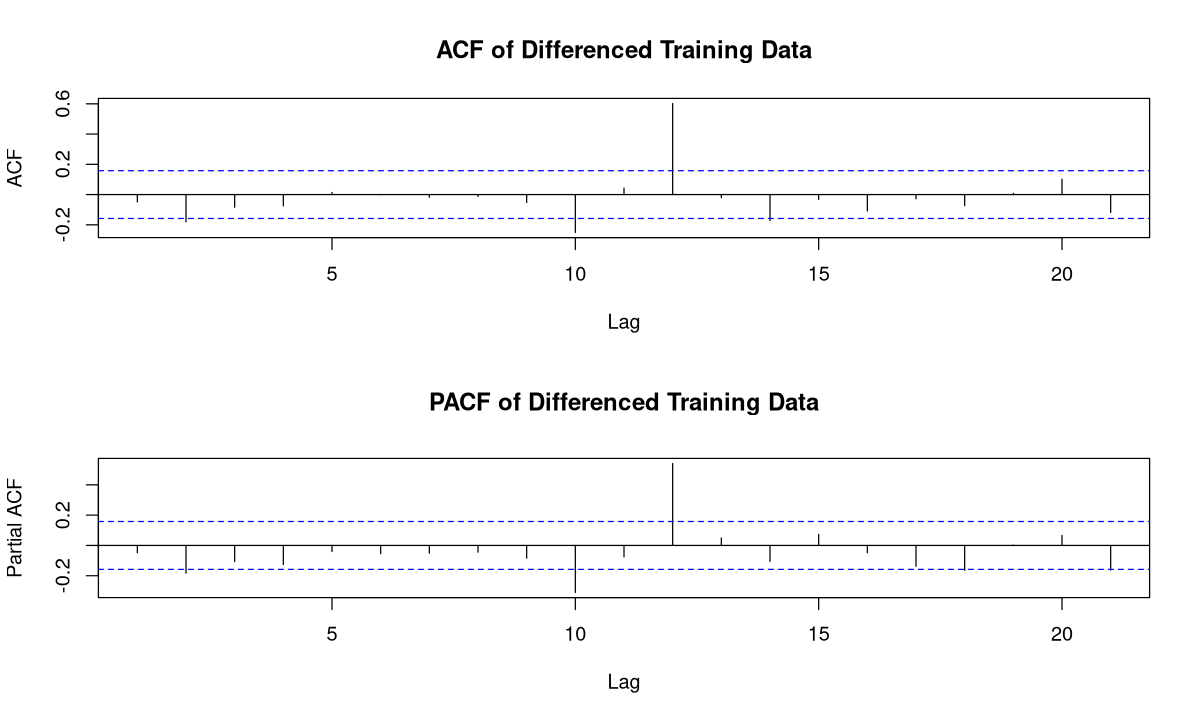

In [15]:
# Plot ACF and PACF
par(mfrow=c(2,1))
acf(differenced_train_data, main="ACF of Differenced Training Data")
pacf(differenced_train_data, main="PACF of Differenced Training Data")

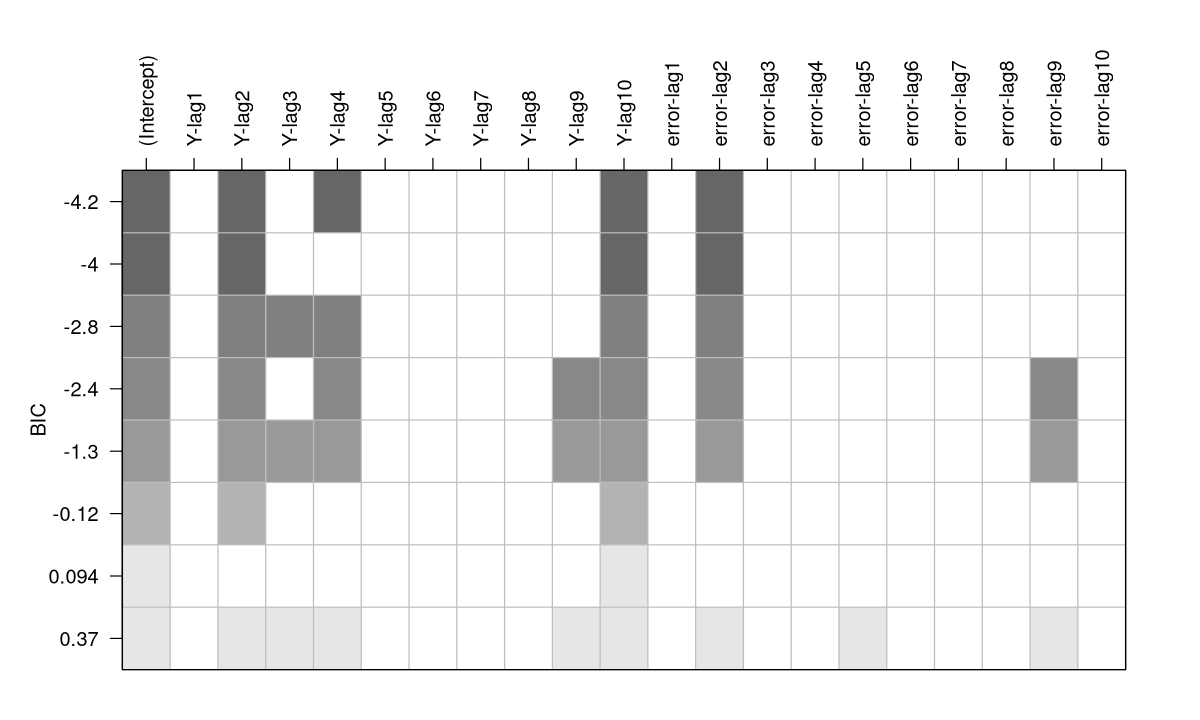

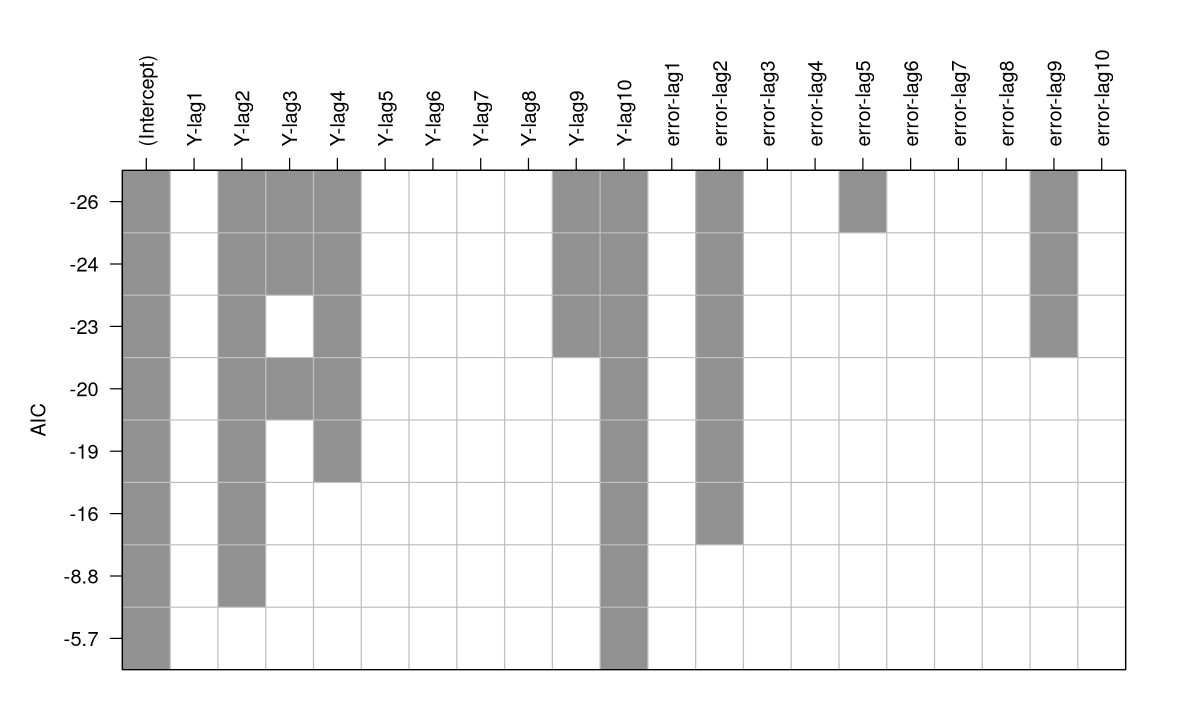

In [16]:
arma_subsets <- armasubsets(differenced_train_data, nar = 10, nma = 10)

#Visualize subsets based on BIC
plot(arma_subsets, scale = "BIC")  # Prioritize model simplicity with BIC

#visualize subsets based on AIC
plot(arma_subsets, scale = "AIC")  




In [17]:
# Use auto.arima to find the best model
best_model <- auto.arima(differenced_train_data)
print("Best ARIMA Model:")
print(best_model)


[1] "Best ARIMA Model:"
Series: differenced_train_data 
ARIMA(1,0,2) with non-zero mean 

Coefficients:
         ar1      ma1      ma2     mean
      0.5014  -0.6214  -0.1796  29.7692
s.e.  0.1806   0.1872   0.1075   9.4912

sigma^2 = 82396:  log likelihood = -1088.24
AIC=2186.48   AICc=2186.88   BIC=2201.66


### Next, I'll select a range of candidate models and conduct residual analysis for each one. Following the Auto ARIMA and BIC tests, I'll opt for ARIMA(1,1,2) and ARIMA(10,1,2).


In [18]:
ARIMA_112 <-  forecast::Arima(transformed_data, order = c(1, 1, 2))

ARIMA_10_1_2 <-   forecast::Arima(transformed_data, order = c(10, 1, 2))


### In this section, I'll create a function for plotting observed data against predicted data and another function for conducting residual analysis.

In [19]:
plot_model_data <- function(data, model)
{

plot(data, main = "Original Time Series Data", xlab = "Time", ylab = "Value", type = "l")

fit <- fitted(model)
lines(fit, col = "red")

legend("topright", legend = c("Original Data", "Fitted Values"), col = c("black", "red"), lty = c(1, 1))
    
}

 In residual diagnosis , we look  at histogram of the residuals and examine QQ plots, as well as ACF plot. We then perform a normality test using the Shapiro-Wilk method and an independence test using the Ljung-Box method. Additionally, we may inspect other relevant graphs for further analysis.


In [20]:
residuals_test <- function(residuals) {
 #plot the residuals 
    plot(residuals , ylab='Standardized residuals',type='l')
    abline(h=0)
    
  # Plot the histogram
  hist(residuals, main = 'Histogram of Residuals')
    
  # ACF  of the residuals
  acf(residuals, main = 'ACF of Residuals')
    
  #boxplot of the residuals
  boxplot(residuals, main = "Boxplot of residuals")  
 
  # Plot the QQ plot
  qqnorm(residuals)
  qqline(residuals, col = "blue")



  # Shapiro-Wilk test for normality
  shapiro_test <- shapiro.test(residuals)
  cat("\nShapiro-Wilk Test for Normality:\n")
  print(shapiro_test)

  # Ljung-Box test for independence
  ljung_box_test <- Box.test(residuals,  type = "Ljung-Box")
  cat("\nLjung-Box Test for Independence:\n")
  print(ljung_box_test)


}


## TEST for arima(1,1,2)

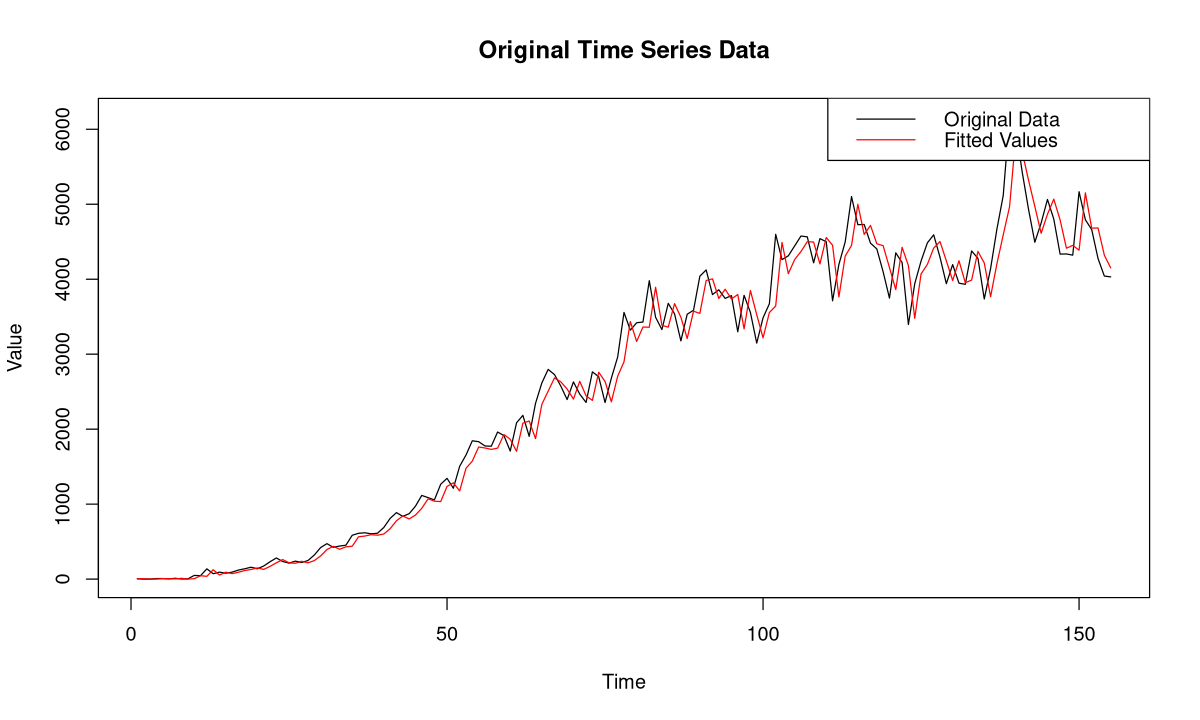

In [21]:
plot_model_data(transformed_data , ARIMA_112)

In [22]:
residuals_ARIMA_112<- rstandard(ARIMA_112)


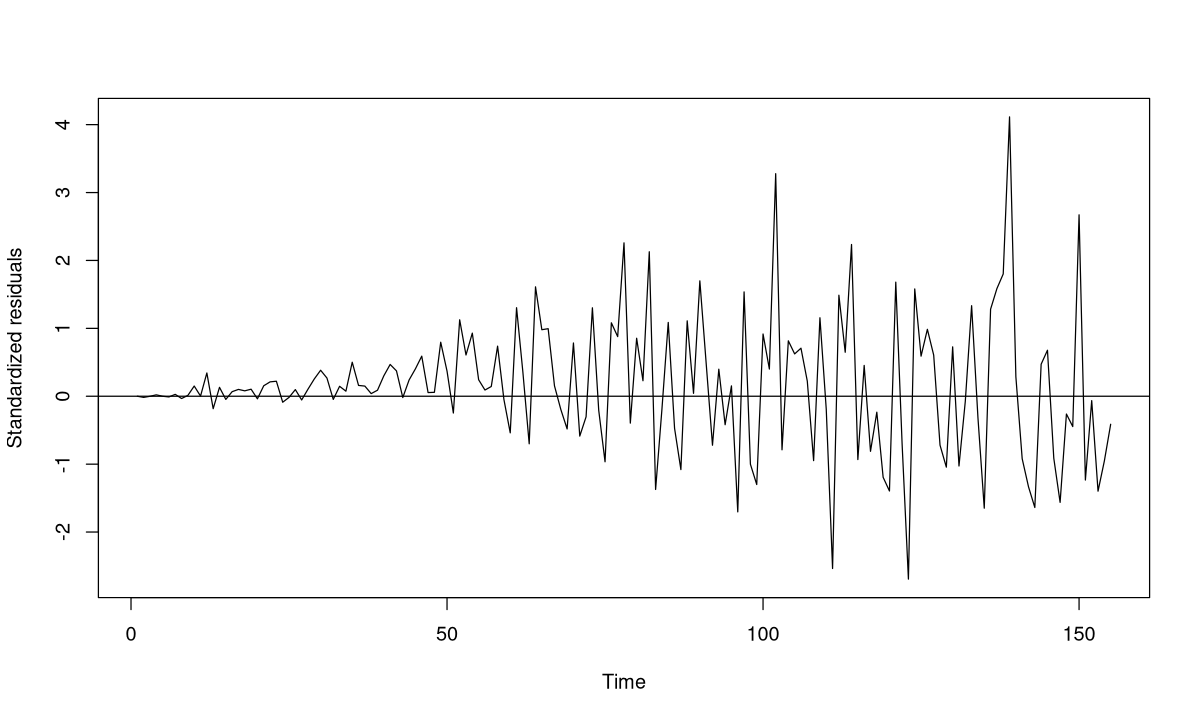

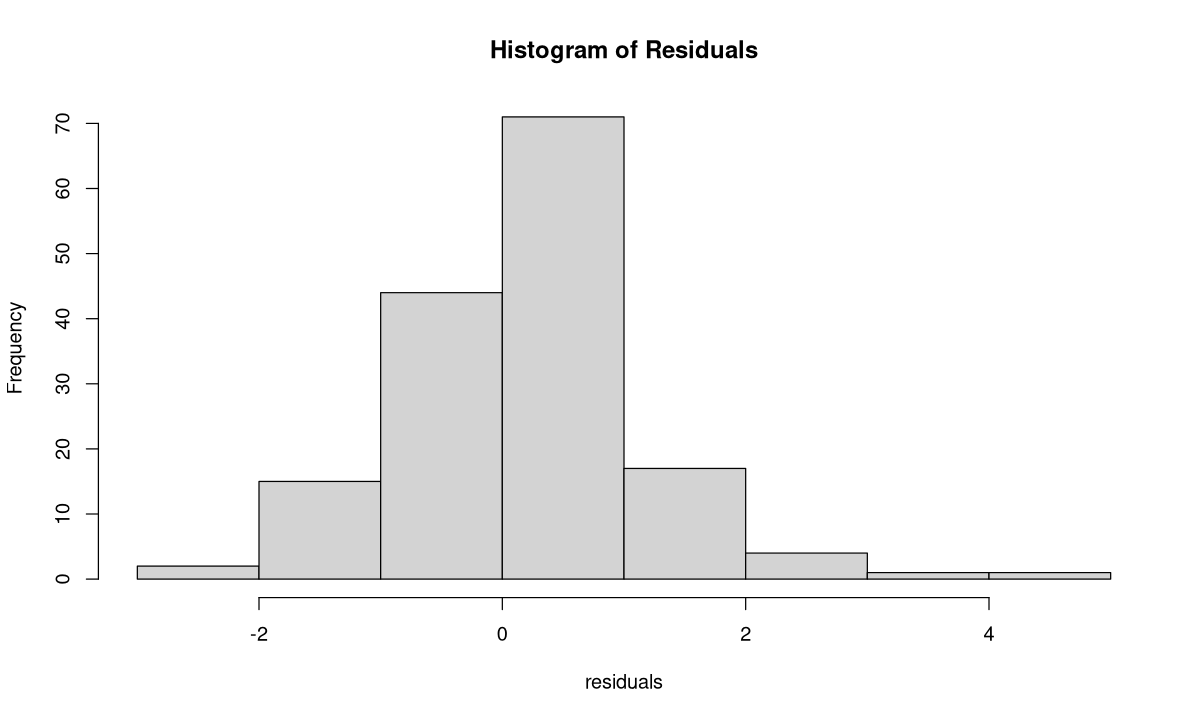

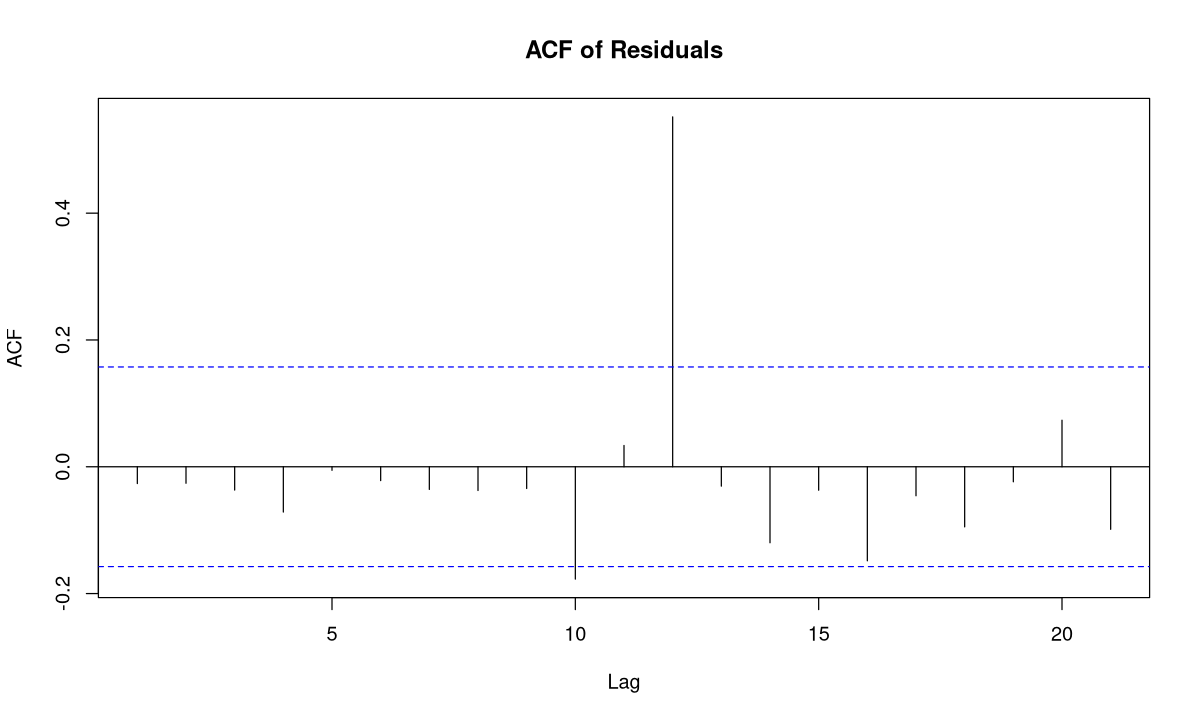

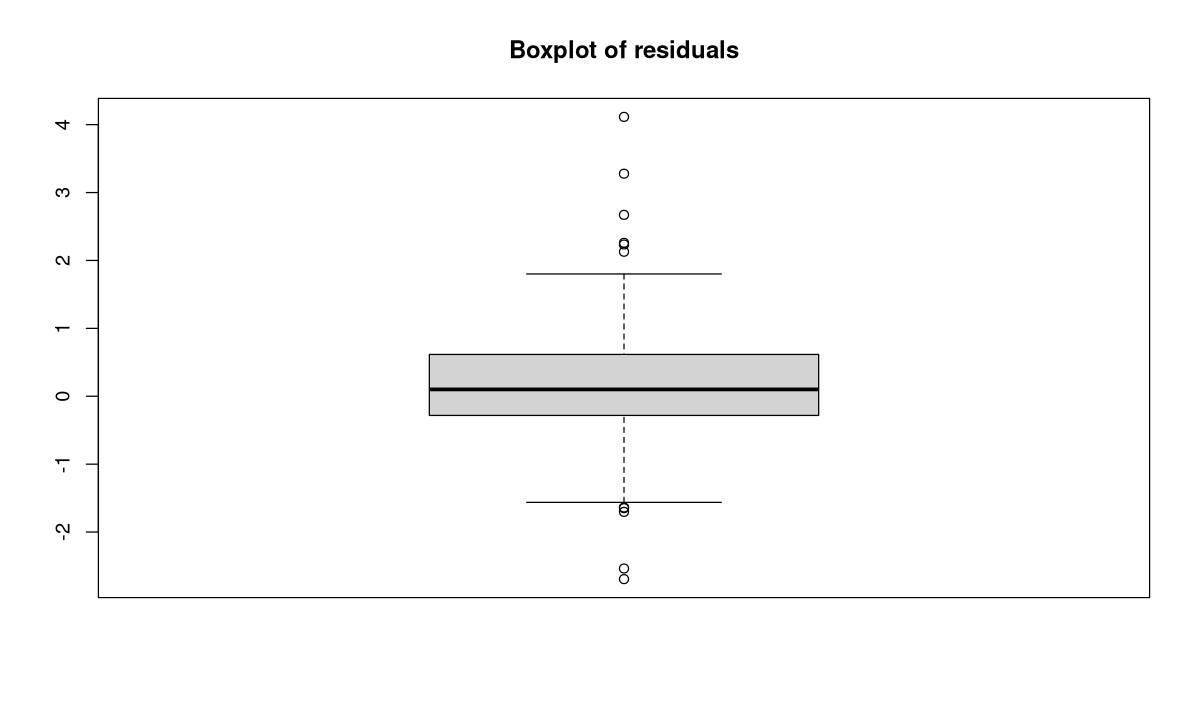


Shapiro-Wilk Test for Normality:

	Shapiro-Wilk normality test

data:  residuals
W = 0.9632, p-value = 0.0003802


Ljung-Box Test for Independence:

	Box-Ljung test

data:  residuals
X-squared = 0.1106, df = 1, p-value = 0.7395



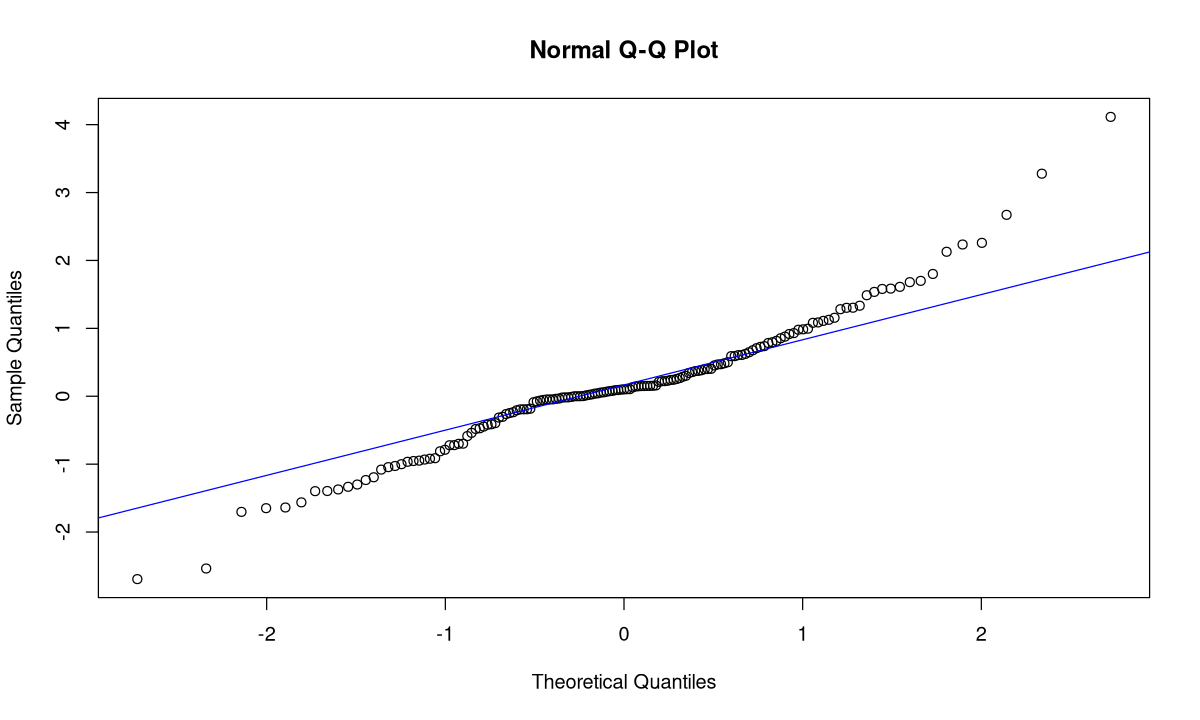

In [23]:
residuals_test(residuals_ARIMA_112)

######  The Shapiro-Wilk test has a p-value of 0.0003802, indicating strong evidence against the null hypothesis of normality. Therefore, you would reject the null hypothesis and conclude that the data is not normally distributed.
###### The Ljung-Box test yields a p-value of 0.7395, indicating strong evidence in favor of the null hypothesis of independence. Consequently, you would retain the null hypothesis and infer the presence of serial independence in the residuals.


### TEST FOR ARIMA(10,1,2)

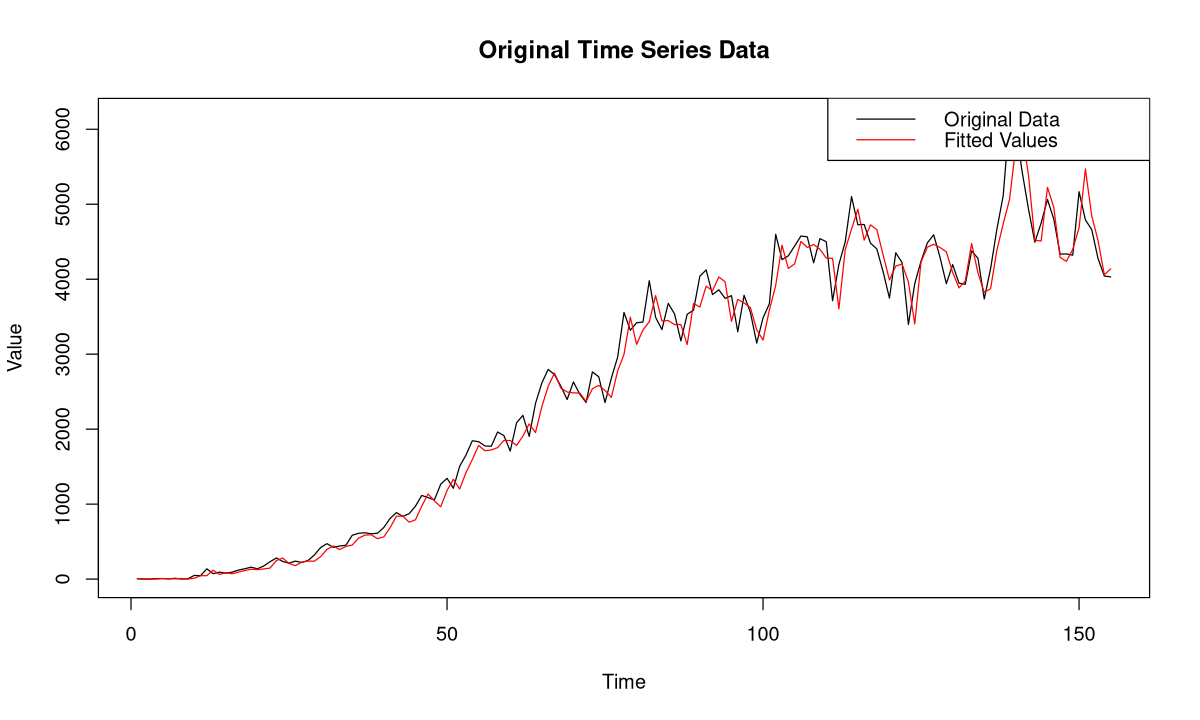

In [24]:
plot_model_data(transformed_data , ARIMA_10_1_2)

In [25]:
residuals_ARIMA_10_1_2<- rstandard(ARIMA_10_1_2)


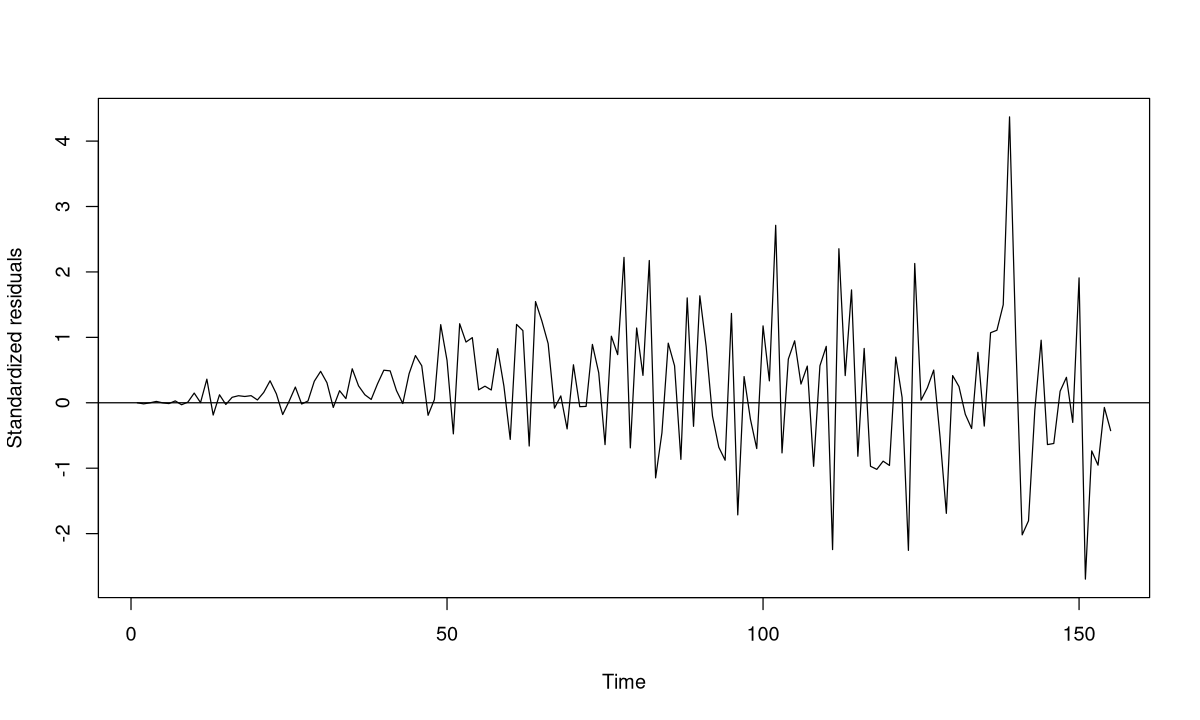

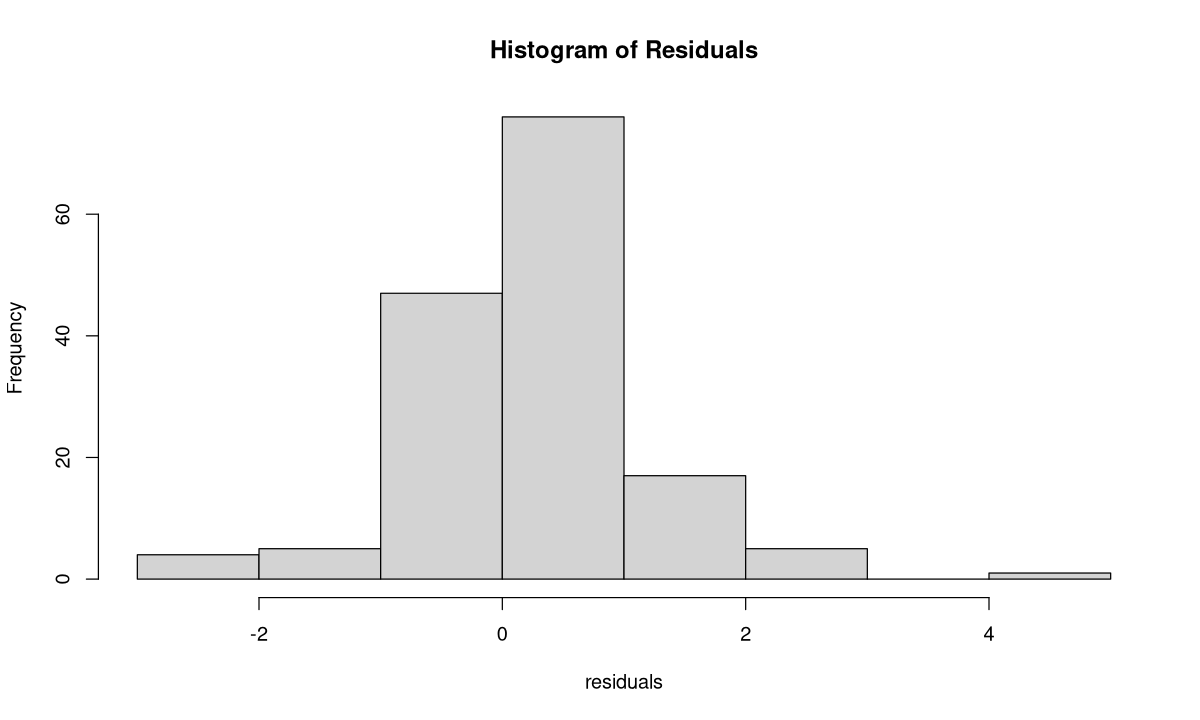

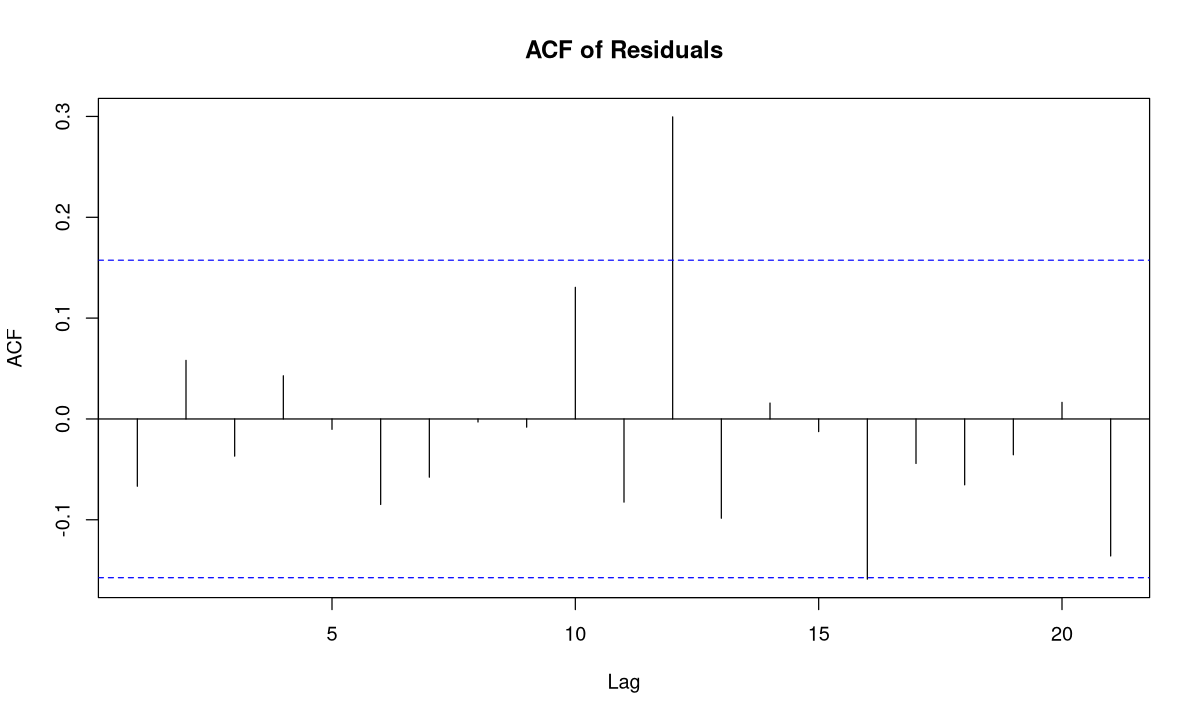

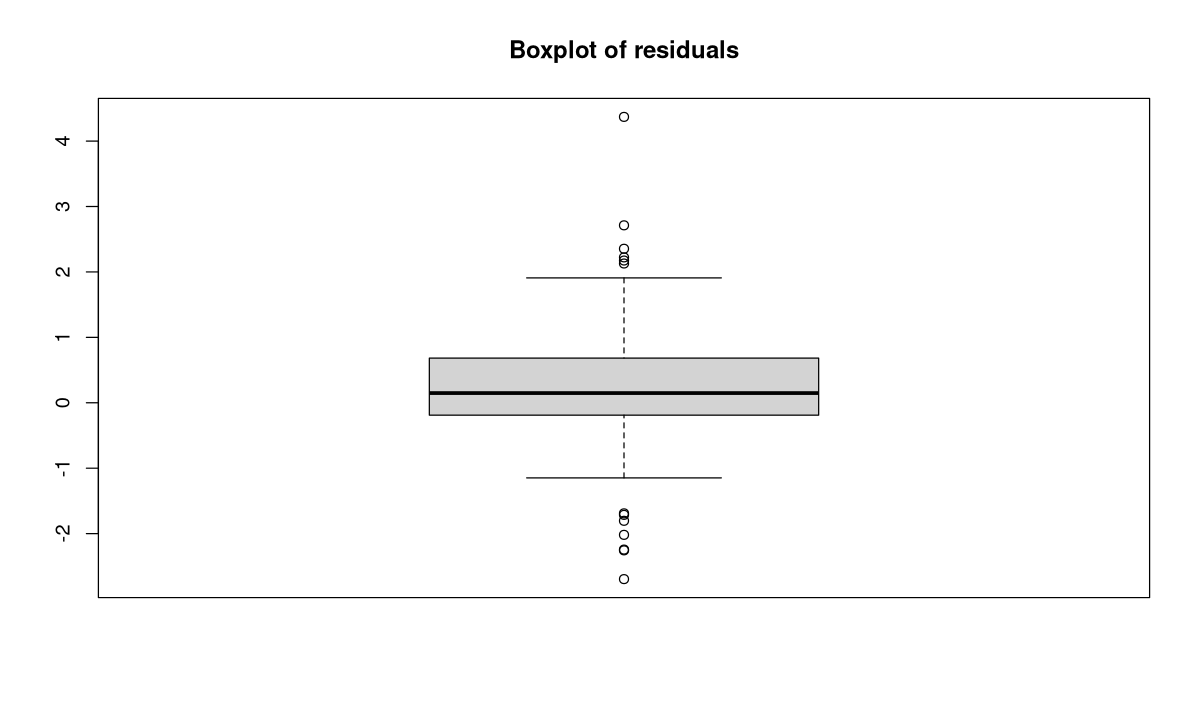


Shapiro-Wilk Test for Normality:

	Shapiro-Wilk normality test

data:  residuals
W = 0.95454, p-value = 5.991e-05


Ljung-Box Test for Independence:

	Box-Ljung test

data:  residuals
X-squared = 0.70342, df = 1, p-value = 0.4016



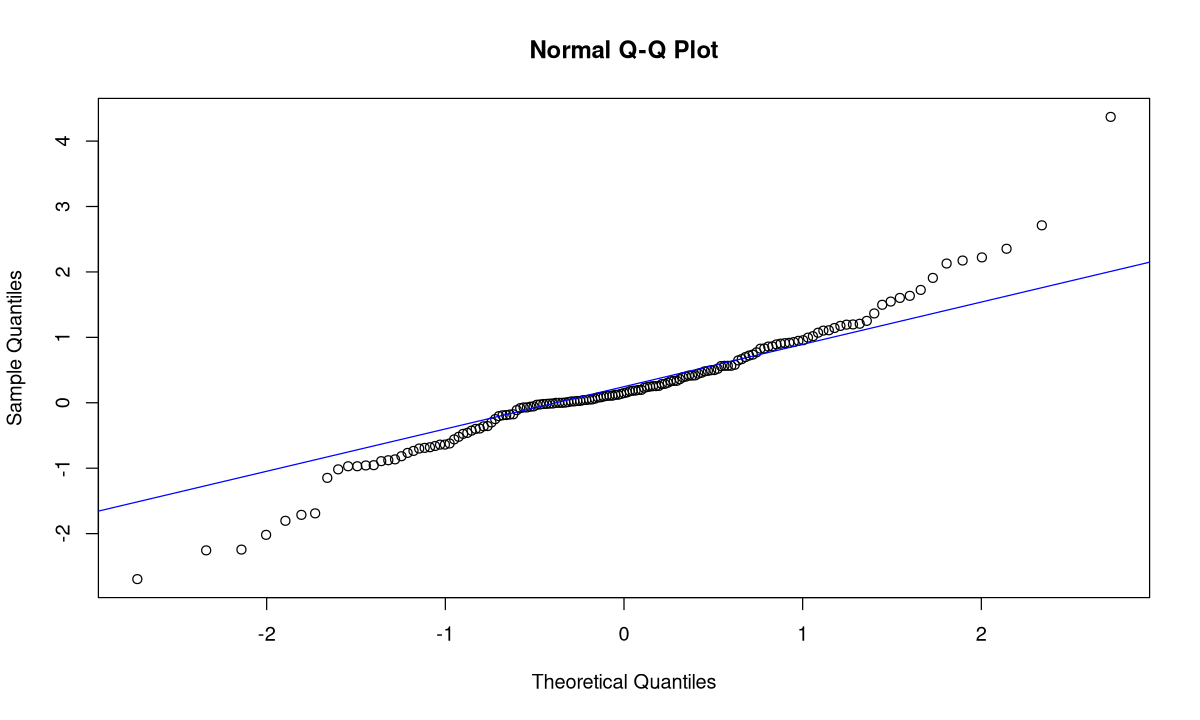

In [26]:
residuals_test(residuals_ARIMA_10_1_2)

######  The Shapiro-Wilk test has a p-value of (5.991e-05) indicating strong evidence against the null hypothesis of normality. Therefore, you would reject the null hypothesis and conclude that the data is not normally distributed.
###### The Ljung-Box test yields a p-value of 0.4016, indicating strong evidence in favor of the null hypothesis of independence. Consequently, you would retain the null hypothesis and infer the presence of serial independence in the residuals.


## Conclusion about the models: 

Here, we observe that neither the ARIMA(1,1,2) nor the ARIMA(10,1,2) models exhibit normally distributed residuals, indicating a lack of fit to the data.

## Forcasting

### Forcasting using ARIMA(1,1,2)

Warning message in forecast.forecast_ARIMA(ARIMA_112, newdata = test_data):
“The non-existent newdata arguments will be ignored.”


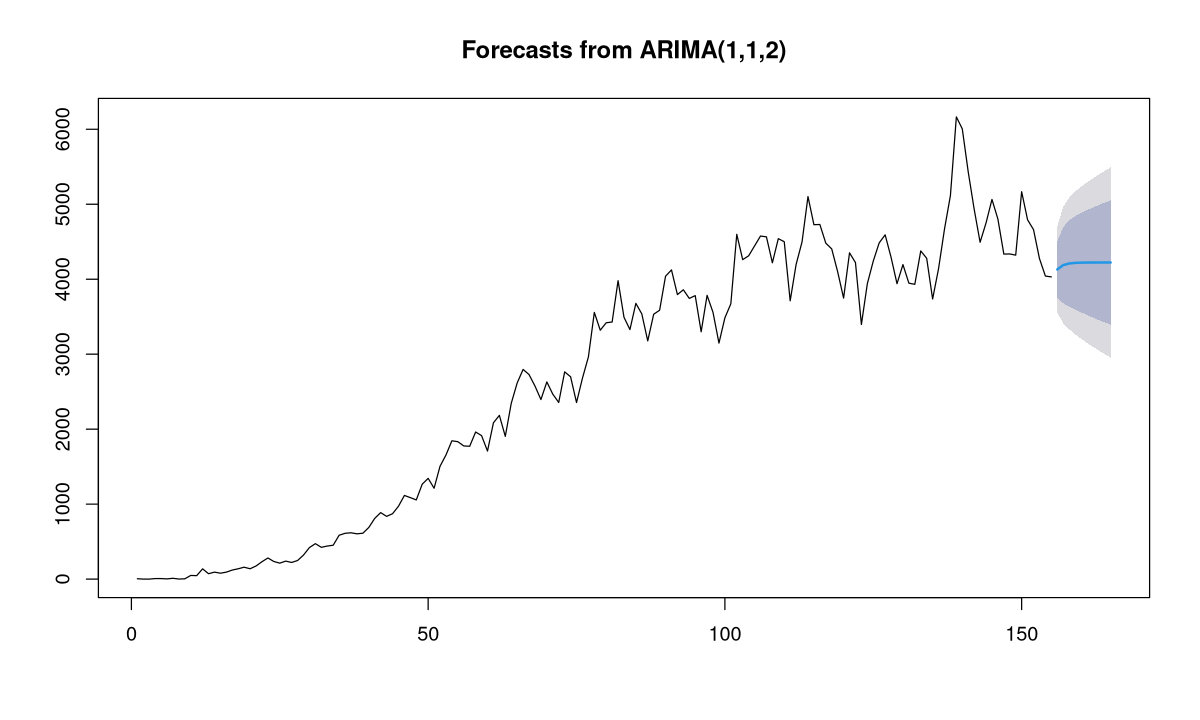

In [27]:
# Forecast using the ARIMA(1,1,2) model
forecast_values <- forecast(ARIMA_112, newdata = test_data)



# Plot the forecast
plot(forecast_values)


Mean Absolute Error (MAE): 988.0747 
Mean Squared Error (MSE): 1682788 
Root Mean Squared Error (RMSE): 1297.223 
Mean Absolute Percentage Error (MAPE): 42.88534 %


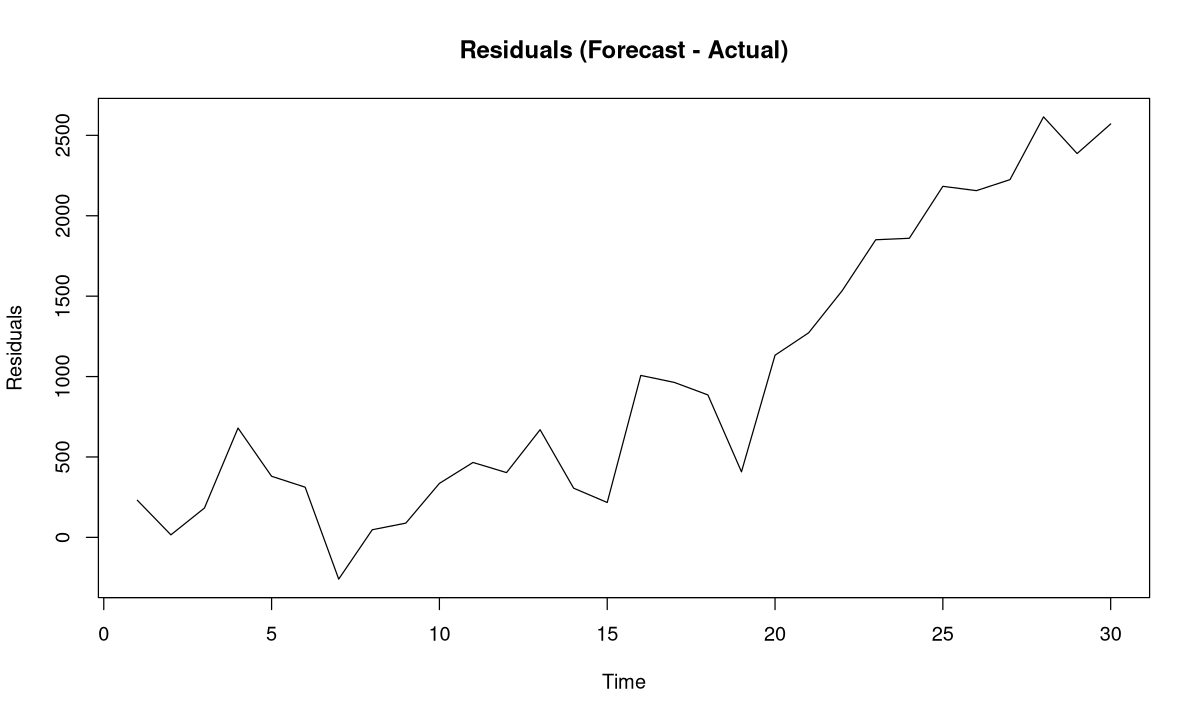

In [28]:
#extract the numeric part
mean_values_numeric <- as.numeric(forecast_values$mean)

# Calculate residuals
residuals <- mean_values_numeric - test_data$R

# Compute evaluation metrics
mae <- mean(abs(residuals))
mse <- mean(residuals^2)
rmse <- sqrt(mse)
mape <- mean(abs(residuals / test_data$R)) * 100

# Print evaluation metrics
cat("Mean Absolute Error (MAE):", mae, "\n")
cat("Mean Squared Error (MSE):", mse, "\n")
cat("Root Mean Squared Error (RMSE):", rmse, "\n")
cat("Mean Absolute Percentage Error (MAPE):", mape, "%\n")

# Plot the residuals
plot(residuals, type = "l", main = "Residuals (Forecast - Actual)", xlab = "Time", ylab = "Residuals")


### Forcasting using ARIMA(10,1,2)

Warning message in forecast.forecast_ARIMA(ARIMA_10_1_2, newdata = test_data):
“The non-existent newdata arguments will be ignored.”


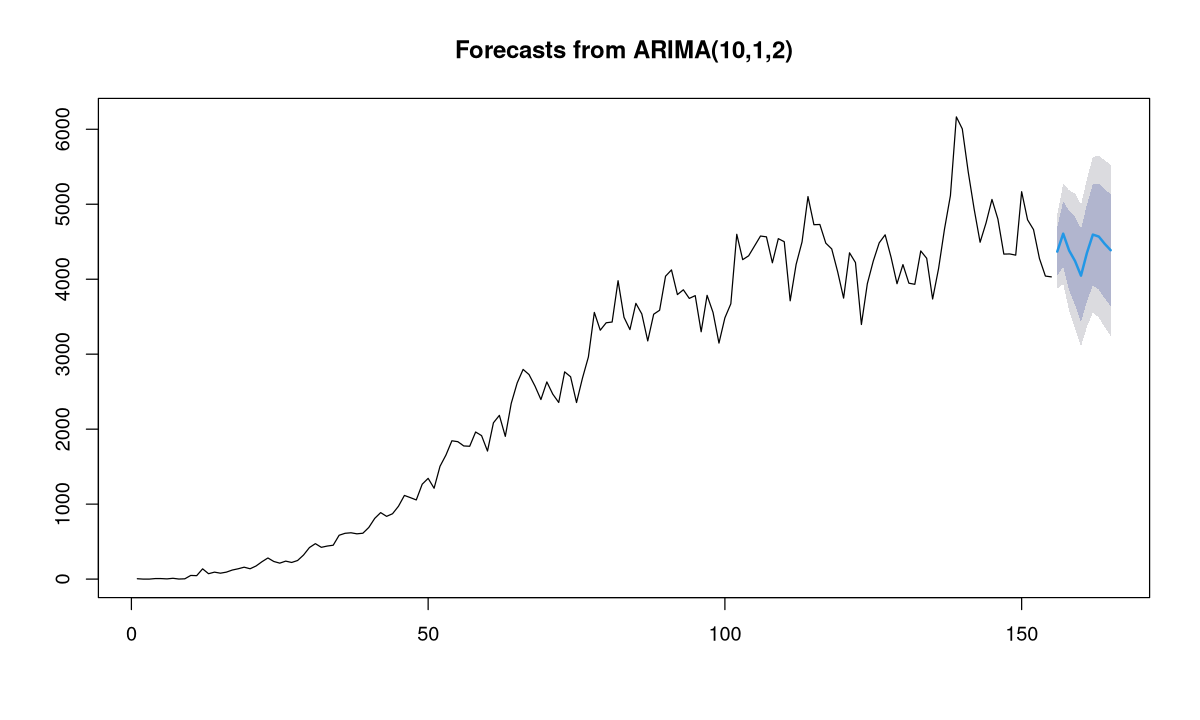

In [29]:
# Forecast using the ARIMA(10,1,2) model
forecast_values_model2 <- forecast(ARIMA_10_1_2, newdata = test_data)



# Plot the forecast
plot(forecast_values_model2)

Mean Absolute Error (MAE): 1164.949 
Mean Squared Error (MSE): 2114389 
Root Mean Squared Error (RMSE): 1454.094 
Mean Absolute Percentage Error (MAPE): 49.06688 %


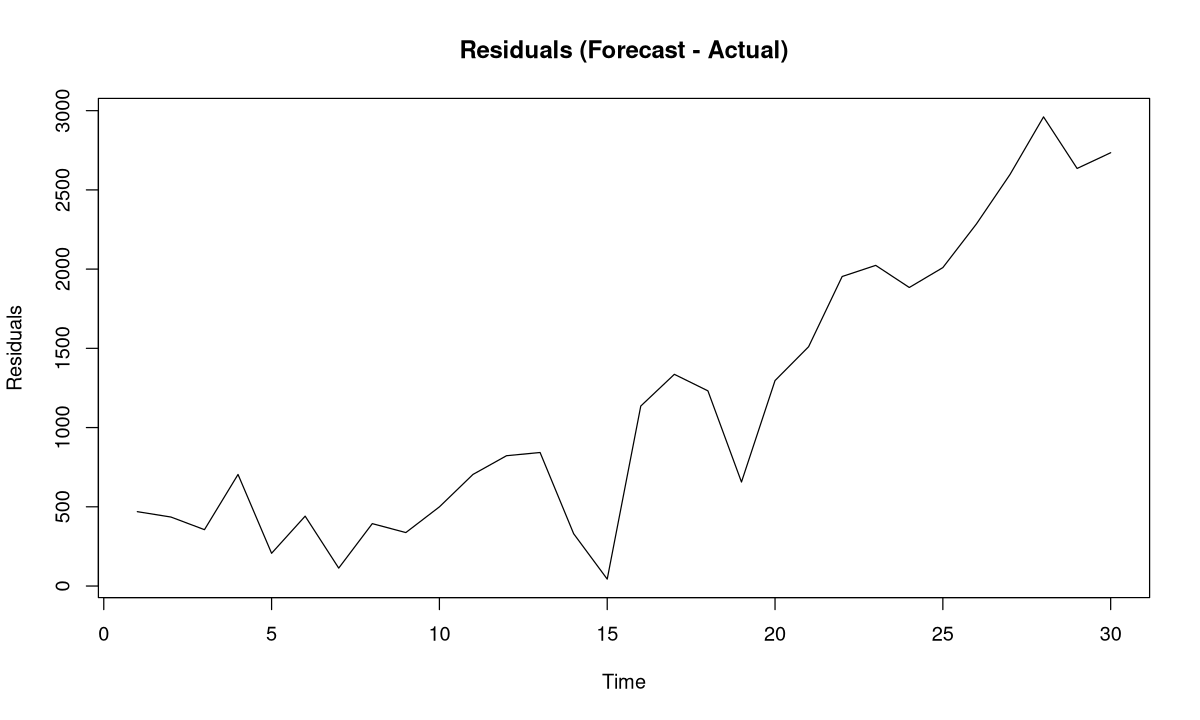

In [30]:
#extract the numeric part
mean_values_numeric <- as.numeric(forecast_values_model2$mean)

# Calculate residuals
residuals <- mean_values_numeric - test_data$R

# Compute evaluation metrics
mae <- mean(abs(residuals))
mse <- mean(residuals^2)
rmse <- sqrt(mse)
mape <- mean(abs(residuals / test_data$R)) * 100

# Print evaluation metrics
cat("Mean Absolute Error (MAE):", mae, "\n")
cat("Mean Squared Error (MSE):", mse, "\n")
cat("Root Mean Squared Error (RMSE):", rmse, "\n")
cat("Mean Absolute Percentage Error (MAPE):", mape, "%\n")

# Plot the residuals
plot(residuals, type = "l", main = "Residuals (Forecast - Actual)", xlab = "Time", ylab = "Residuals")


## ADITIONAL: try to fit the data with regression model

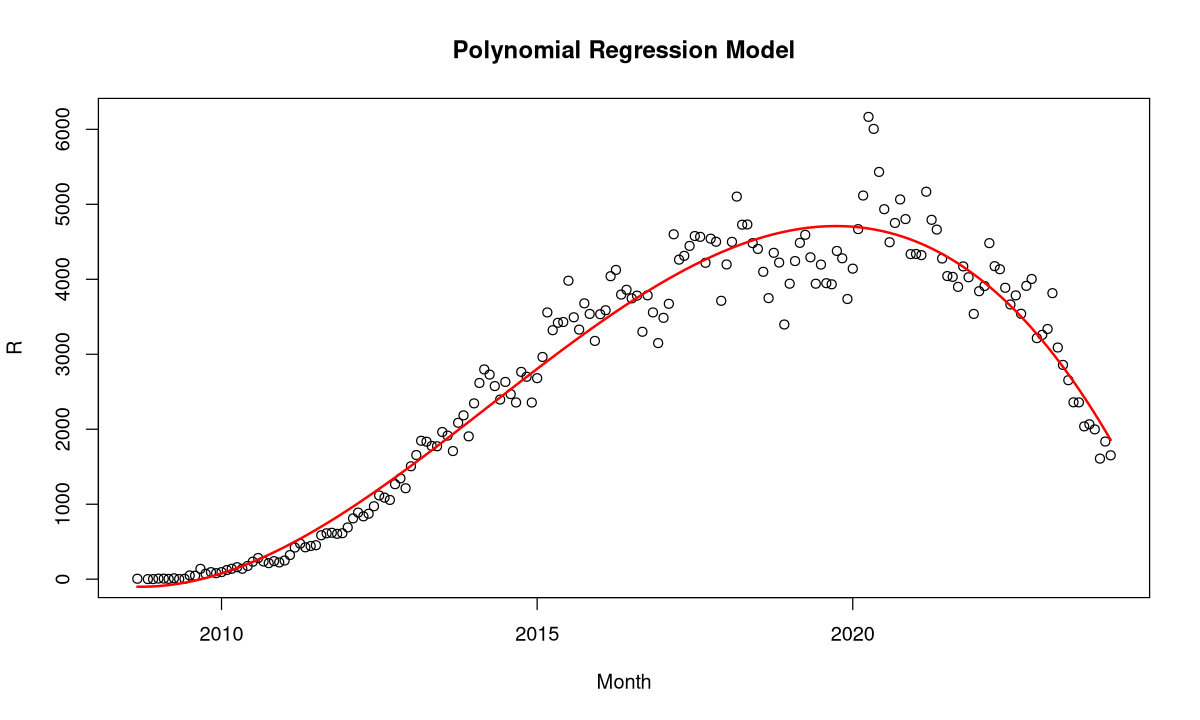

In [31]:
# Fit a polynomial regression model
model <- lm(R ~ poly(Month, degree = 3, raw = TRUE), data = data)

new_dates <- seq(min(data$Month), max(data$Month), by = "month")

predicted <- predict(model, newdata = data.frame(Month = new_dates))

# Get residuals
residuals <- resid(model)

# Plot the data and regression model
plot(data$Month, data$R, xlab = "Month", ylab = "R", main = "Polynomial Regression Model")
lines(new_dates, predicted, col = "red", lwd = 2)


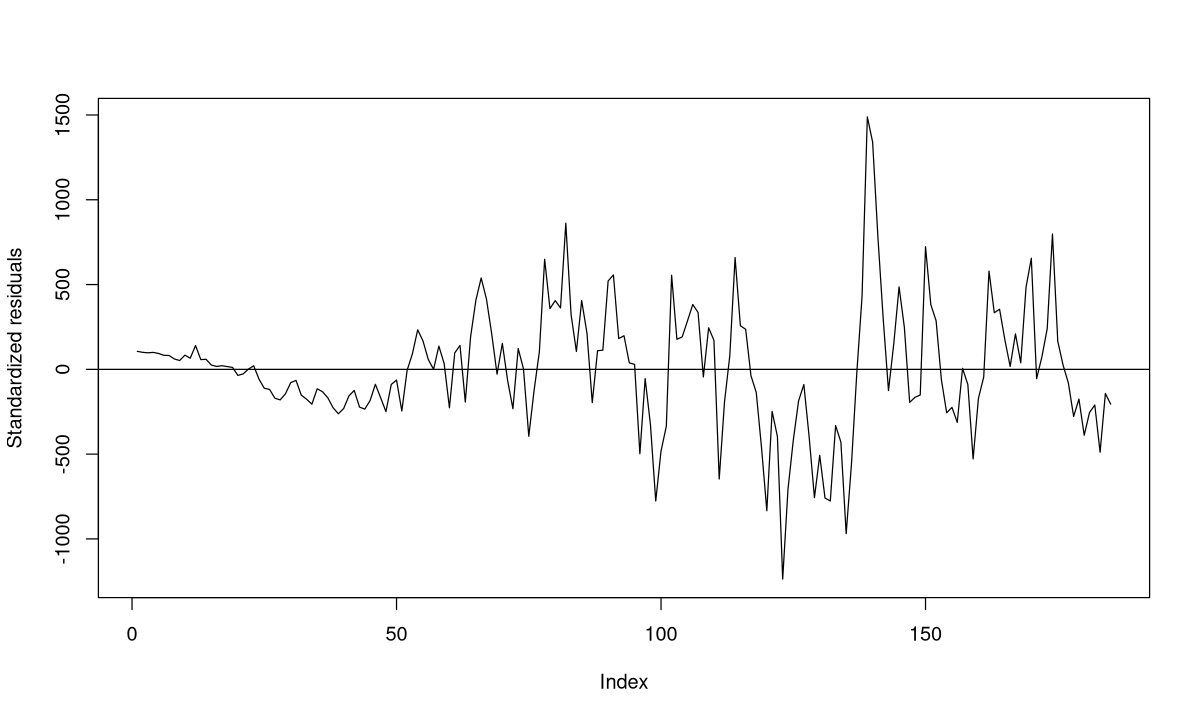

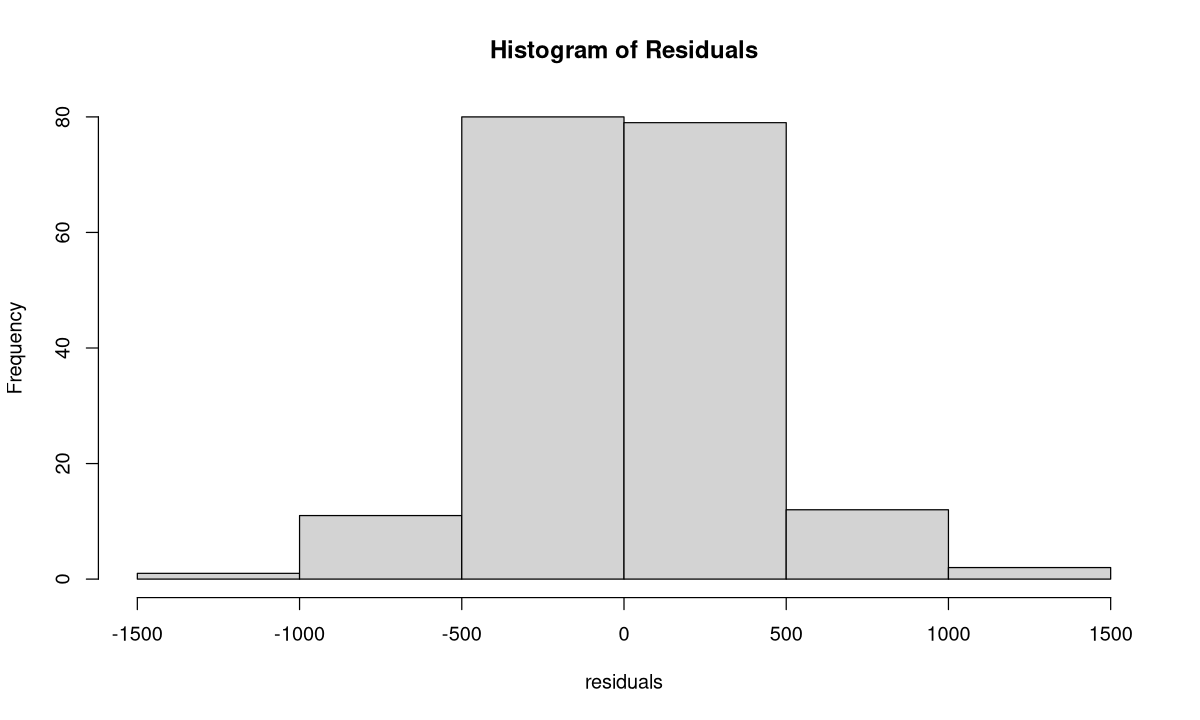

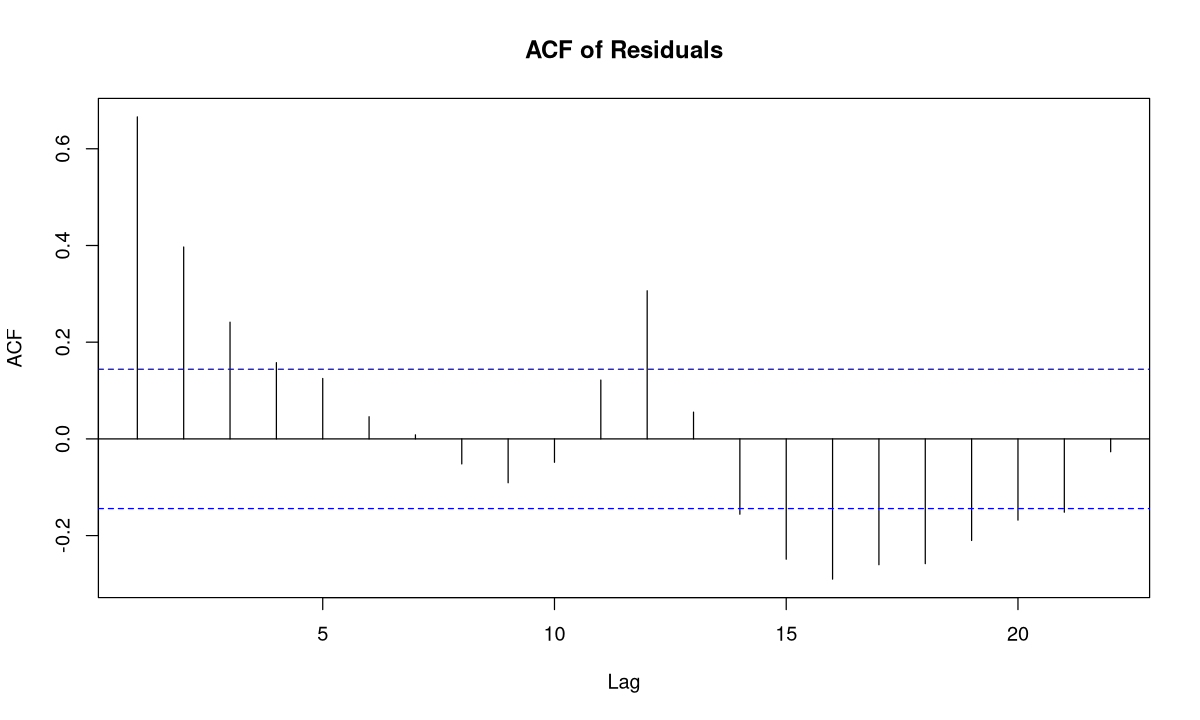

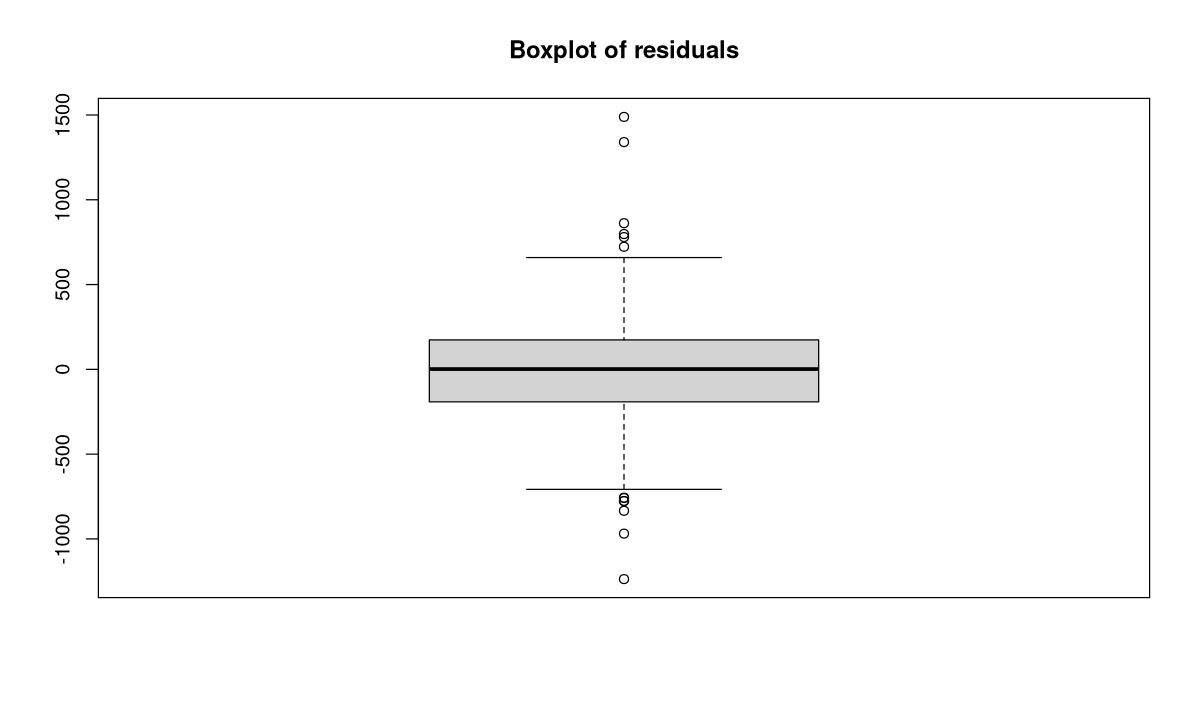


Shapiro-Wilk Test for Normality:

	Shapiro-Wilk normality test

data:  residuals
W = 0.96229, p-value = 7.129e-05


Ljung-Box Test for Independence:

	Box-Ljung test

data:  residuals
X-squared = 83.39, df = 1, p-value < 2.2e-16



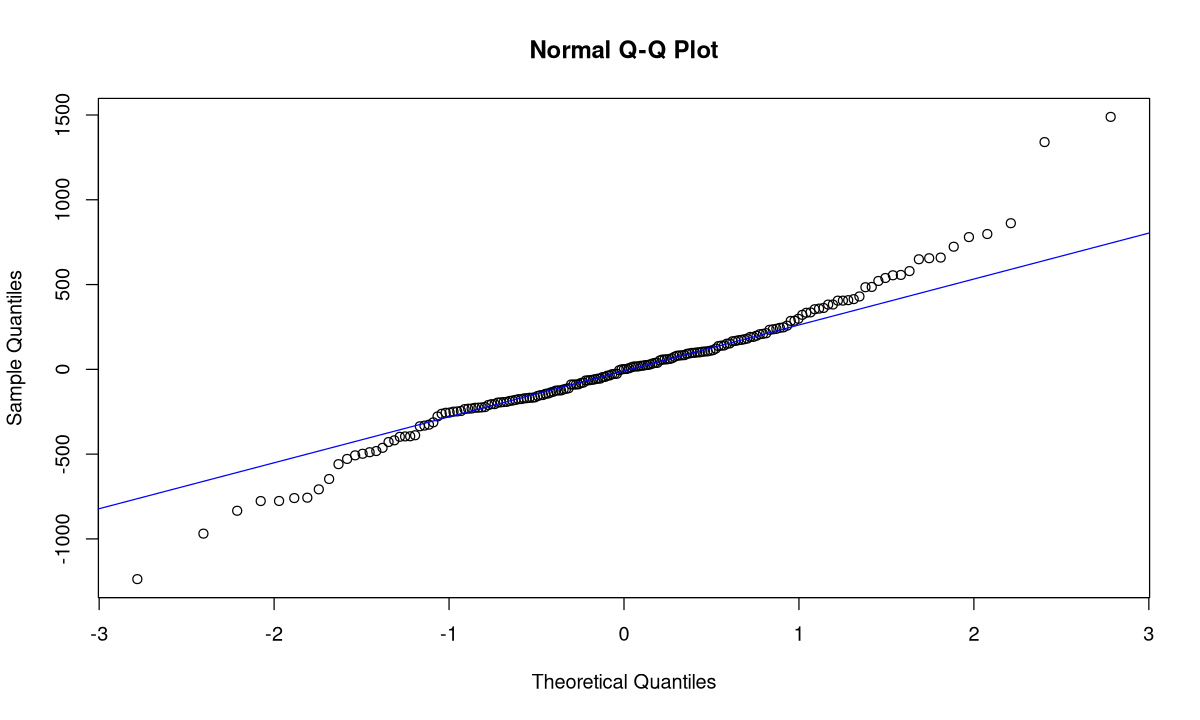

In [32]:
residuals_test(residuals)

### we also see that the residuals are not normally distributed and they are correlated